<h1 align="center"><font color = "#4D5762">Olympic History Analysis</font></h1>

______

<h2><font color='#0E2545'>Table of Contents</font></h2>

<br>
<ul class="table-contents" style="border: solid 0.5px #4D5762; width: 33%; padding: 3%; list-style: none; font-size: 18px;">

<li class="content-name" style = "margin-bottom: 10px;"><a style = "text-decoration: none" href ="#Introduction">Introduction</a></li>


<li class="content-name" style = "margin-bottom: 10px;"><a style = "text-decoration: none" href ="#Data-Analytic-Question">Data Analytics Question</a></li>


<li class="content-name" style = "margin-bottom: 10px;"><a style = "text-decoration: none" href="#Step-1.-Loading-the-Data">Step 1. Loading the Data</a> 
    
  <ul class="sub-table-contents" style="list-style:none; margin-top: 10px !important;">
      <li class="content-name" style = "margin-bottom: 10px;" ><a style = "text-decoration: none" href="#Step-1.A-Loading-the-given-dataset">A. Loading the given dataset</a></li>
  
  <li class="content-name" style = "margin-bottom: 10px;" ><a style = "text-decoration: none" href="#Step-1.B-Web-Scraping-Wikipedia">B. Web Scraping Wikipedia</a></li>
  </ul>
 </li>
  
<li class="content-name" style = "margin-bottom: 10px;"><a style = "text-decoration: none" href="#Step-2.-Checking-the-Data">Step 2. Checking the Data</a></li>


<li class="content-name" style = "margin-bottom: 10px;"><a style = "text-decoration: none" href = "#Step-3.-Data-Tidying">Step 3. Data Tidying</a></li>


<li class="content-name" style = "margin-bottom: 10px;"><a style = "text-decoration: none" href="#Step-4.-Exploratory-Analysis">Step 4. Exploratory Analysis</a></li>
  <ul class="sub-table-contents" style="list-style:none; margin-top: 10px !important;">
      <li class="content-name" style = "margin-bottom: 10px;" ><a style = "text-decoration: none" href="#4.A-Women-Participations">A. Women Participations</a></li>
  
  <li class="content-name" style = "margin-bottom: 10px;" ><a style = "text-decoration: none" href="#4.B.-Can-we-know-if-an-athlete-will-win-gold-just-based-on-his/her-nationality?">B. Can we know if an athlete will win gold just based on his/her nationality?</a></li>
  </ul>
</ul>

______

<h2><font color='#0E2545'>Introduction</font></h2>

<a href="#Table-of-Contents">Got top &uarr;</a>

Let's pretend we're a team of *risk-takers* , aka gamblers, with a background in data science. Usually we always keep an eye on every competition where we have greater chances to earn a big amount of money. 

The Tokyo's 2020 Summer Olympic games are going to start in a couple of months and we are really excited, since recently we got a dataset that contains about 120 years of history from the previous olympic games. We are planning to use this dataset in order to make some predictions and see which are the possible winners per event on which we can bet and earn the most.

<h2><font color='#0E2545'>Data Analytic Question</font></h2>

<a href="#Table-of-Contents">Got top &uarr;</a>

Our goal is to earn a lot of money, so we just want to consider the most popular sports, since they are the ones with the highest revenues. 
In order to achieve this, we are asking ourselves the following question:
* **Which are the athletes, from the most popular sports, that are going to win gold?**

<h2><font color='#0E2545'>Step 1. Loading the Data</font></h2>

<a href="#Table-of-Contents">Got top &uarr;</a>

As we explained at the beginning, we got the [<font color='blue'>120 years of Olympic History</font>](https://www.kaggle.com/heesoo37/120-years-of-olympic-history-athletes-and-results) dataset, but we also just want to know which are considered the most popular sports, so for this task we are going to web scrape the Wikipedia article: [<font color='blue'>Olympic sports</font>](https://en.wikipedia.org/wiki/Olympic_sports#Classification_of_Olympic_sports_for_revenue_share)

In the Olympic sports article, it manages popularity using the following categories:
* A, B, C, D, E. Where the category A represents the most popular, while the category E represents the least popular. For these analysis we'll only going to consider categories **A and B**.

Each event from the Olympics is based on a discipline, so we also need to know which disciplines correspond to each sport. Since in the previous article each discipline is grouped by the sport's federation, we need to map each sport with its federation. 

In order to achieve this, we'll use the following article:
[<font color='blue'>Association of Summer Olympic International Federations
</font>](https://en.wikipedia.org/wiki/Association_of_Summer_Olympic_International_Federations#Members)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sb
import re
import numpy as np
import pandas as pd
import scipy.stats as stats
import requests as r
from bs4 import BeautifulSoup

In [2]:
def get_wiki_article(url = "https://en.wikipedia.org/wiki/Olympic_sports"):
    article = r.get(url).text
    return BeautifulSoup(article)

def add_sport_info(pss_data,category,sports,sport_type):
    sport_amount = len(sports)
    pss_data["SPORT"] += [sport.capitalize() for sport in sports] 
    pss_data["CATEGORY"] += [category] * sport_amount
    pss_data["TYPE"] += [sport_type.capitalize()] * sport_amount
    return pss_data

#Obtains data about current olympic summer sports by scraping a certain table from a Wikipedia article
def get_summer_sports_popularity(article):

    
    #The table contains the following fields
    #Category -> Index 0, represents how popular the sport is (A-E)
    #Individual Sport -> Index 1, which sports are individual
    #Team Sport -> Index 2, which sports are team based.
    pss_data = {
        "CATEGORY": [],
        "SPORT": [],
        "TYPE": []
    }
    pss_table = soup.find_all("table", class_="wikitable")[1]
    pss_rows = pss_table.find_all("tr")
    for index, row in enumerate(pss_rows):
        #Not considering the header
        if index == 0:
            continue
        columns = row.find_all("td")
        category = columns[0].text
        pattern = re.compile(r'((?:\w+)(?:\s*\w+)*)',re.I)
        
        #Add individual sports
        individual_sports = re.findall(pattern,columns[1].text)
        pss_data = add_sport_info(pss_data,category,individual_sports, "individual")
        
        #Add team sports
        team_sports =  re.findall(pattern,columns[2].text)
        pss_data = add_sport_info(pss_data,category,team_sports, "team")
        
    return pd.DataFrame(pss_data)


#Gets the federation for each sport by scraping a certain table from a Wikipedia article
def get_federation_per_sport(sports, 
                             url="https://en.wikipedia.org/wiki/Association_of_Summer_Olympic_International_Federations"):
    soup = get_wiki_article(url)
    sport_x_fed = {}
    fps_table = soup.find_all("table", class_="wikitable")[1]
    fps_rows = fps_table.find_all("tr")
    for index, row in enumerate(fps_rows):
        #Not considering the header
        if index == 0:
            continue
        columns = row.find_all("td")
        
        sport_name = columns[0].text
        sport_fed_acronym = columns[2].text
        for sport in sports:
            if sport not in sport_x_fed:
                #match at least the first 3 letters of the sport
                pattern = re.compile(r'('+sport[0:3]+')',re.I)
                if re.match(pattern,sport_name):
                    sport_x_fed[sport_fed_acronym] = sport
                    break
                    
    return sport_x_fed

#Obtain each sport's disciplines using its federation
#just consider the disciplines that were official during the past 5 Olympic games
def get_disciplines_per_sport(soup, federation_per_sport):
    disciplines_per_sport = {
        "DISCIPLINE": [],
        "SPORT": []
    }
    dps_table = soup.find_all("table", class_="wikitable")[0]
    dps_rows = dps_table.find_all("tr")
    
    #The table contains some rows that act as separators, no need to be considered
    separator_background = "#ddd"
    last_discipline_background = None
    current_federation = ""
    for index, row in enumerate(dps_rows):
        #We know that the first 4 rows are just headers and separators
        if index < 4:
            continue
            
        #Each discipline is identified by its background color    
        if row.get("style") is not None or row.get("bgcolor") is not None:
            background = row.get("bgcolor")
            if background is None:
                background = re.search(r'(?<=background\:)#*[A-Za-z0-9]+',row["style"])
                background = background.group(0)
            #It is a separator, then skip it
            if background.upper() == separator_background.upper():
                continue
                
            columns = row.find_all("td")
            discipline_name = columns[0].text
            
            if last_discipline_background != background:
                last_discipline_background = background
                current_federation = columns[2].text.strip()
            
            if current_federation not in federation_per_sport:
                continue
            
            #If it wasn't during the 5 previous olympic games
            if columns[-5].text == "":
                continue
            
            sport_name = federation_per_sport[current_federation]
            disciplines_per_sport["DISCIPLINE"].append(discipline_name)
            disciplines_per_sport["SPORT"].append(sport_name)
    
    #If the sport doesn't have any disciplines, just add it
    for fed,sport in federation_per_sport.items():
        if sport not in disciplines_per_sport["SPORT"]:
            disciplines_per_sport["SPORT"].append(sport)
            disciplines_per_sport["DISCIPLINE"].append(sport)
            
    return pd.DataFrame(disciplines_per_sport)
    

<h3>Step 1.A Loading the given dataset</h3>

<a href="#Table-of-Contents">Got top &uarr;</a>

In [3]:
#Load given data sets
athlete_events_df = pd.read_csv("athlete_events.csv")
noc_regions_df = pd.read_csv("noc_regions.csv")

#Just for naming convention
athlete_events_df.columns = [column.upper() for column in athlete_events_df.columns]
noc_regions_df.columns = [column.upper() for column in noc_regions_df.columns]

print("Shape: ", athlete_events_df.shape)
athlete_events_df.head(5)

Shape:  (271116, 15)


,ID,NAME,SEX,AGE,HEIGHT,WEIGHT,TEAM,NOC,GAMES,YEAR,SEASON,CITY,SPORT,EVENT,MEDAL
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


Our data set contains around 271K participations, but we need to filter it, since we only want to consider *Summer Sports*

In [4]:
#Filter just Summer sports
athlete_events_df = athlete_events_df[athlete_events_df.SEASON == "Summer"]

#Merge the athlete events table with the noc_regions
#Singapore athletes have issues since the NOC is not the same in both tables
athlete_events_df = athlete_events_df.merge(noc_regions_df,on=["NOC"], how = "left")

print("Shape: ", athlete_events_df.shape)
athlete_events_df.head(5)


Shape:  (222552, 17)


,ID,NAME,SEX,AGE,HEIGHT,WEIGHT,TEAM,NOC,GAMES,YEAR,SEASON,CITY,SPORT,EVENT,MEDAL,REGION,NOTES
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN,China,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN,China,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN,Denmark,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,Denmark,NaN
4,8,"Cornelia ""Cor"" Aalten (-Strannood)",F,18.0,168.0,NaN,Netherlands,NED,1932 Summer,1932,Summer,Los Angeles,Athletics,Athletics Women's 100 metres,NaN,Netherlands,NaN


After filtering and joining our dataset, we ended having around 222K participations. Now, we just need to know which events are the most popular!.

<h3>Step 1.B Web Scraping Wikipedia</h3>

<a href="#Table-of-Contents">Got top &uarr;</a>

At this point, we are going to get the olympic sports' popularity, and only consider the A and B categories.

Our new dataset contains the most popular sports and if they are played individually or by team.

In [5]:
soup = get_wiki_article("https://en.wikipedia.org/wiki/Olympic_sports")
summer_sports_pd = get_summer_sports_popularity(soup)
summer_sports_pd.head(10)

,CATEGORY,SPORT,TYPE
0,A,Athletics,Individual
1,A,Aquatics,Individual
2,A,Gymnastics,Individual
3,B,Cycling,Individual
4,B,Tennis,Individual
5,B,Basketball,Team
6,B,Football,Team
7,B,Volleyball,Team
8,C,Archery,Individual
9,C,Badminton,Individual


After obtaining the data from Wikipedia, its time to just consider the most popular ones, categories A and B.

In [6]:
#We just consider the most popular, in this case Categories A,B 
print("All Categories:",summer_sports_pd.CATEGORY.unique())
summer_sports_pd = summer_sports_pd[summer_sports_pd["CATEGORY"].str.match(r'[AB]')]
print("Considered Categories:",summer_sports_pd.CATEGORY.unique())
print("Considered Sports:",  summer_sports_pd.SPORT.unique())

All Categories: ['A' 'B' 'C' 'D' 'E']
Considered Categories: ['A' 'B']
Considered Sports: ['Athletics' 'Aquatics' 'Gymnastics' 'Cycling' 'Tennis' 'Basketball'
 'Football' 'Volleyball']


Now we found out that the most popular sports are:
* Athletics
* Aquatics
* Gymnastics
* Cycling
* Tennis
* Basketball

Now we need to know which disciplines the sport includes. The [<font color='blue'>Olympic sports</font>](https://en.wikipedia.org/wiki/Olympic_sports#Current_and_discontinued_summer_program) Wikipedia article contains the disciplines per sport, but we need the sport's federation in order to recognize to which sport the discipline corresponds.
For these task, we are going to also use the [<font color='blue'>Association of Summer Olympic International Federations
</font>](https://en.wikipedia.org/wiki/Association_of_Summer_Olympic_International_Federations#Members) article.

In [7]:
sports = summer_sports_pd.SPORT.unique()
federation_per_sport = get_federation_per_sport(sports)
federation_per_sport

{'FINA': 'Aquatics',
 'IAAF': 'Athletics',
 'WBSC': 'Basketball',
 'FIBA': 'Basketball',
 'UCI': 'Cycling',
 'FIFA': 'Football',
 'FIG': 'Gymnastics',
 'ITF': 'Tennis',
 'FIVB': 'Volleyball'}

Finally it's time to map each discipline per sport.

In [8]:
disciplines_sports_pd = get_disciplines_per_sport(soup,federation_per_sport)
disciplines_sports_pd = disciplines_sports_pd.merge(summer_sports_pd, on="SPORT", how="inner")
disciplines_sports_pd.columns = ["DISCIPLINE", "MAIN_SPORT","CATEGORY","TYPE"]
disciplines_sports_pd.head(5)

,DISCIPLINE,MAIN_SPORT,CATEGORY,TYPE
0,Diving,Aquatics,A,Individual
1,Swimming,Aquatics,A,Individual
2,Synchronized swimming,Aquatics,A,Individual
3,Water polo,Aquatics,A,Individual
4,Basketball,Basketball,B,Team


Now, lets verify if each obtained discipline is included in the given dataset.

In [9]:
def verify_sport_name():
    convert_to_upper_case = lambda sport: sport.upper().strip()

    obtained_disciplines = list(map(convert_to_upper_case, disciplines_sports_pd.DISCIPLINE.unique()))
    given_disciplines = list(map(convert_to_upper_case, athlete_events_df.SPORT.unique()))

    for od in obtained_disciplines:
        #Is not in the athlete events dataset
        if od.strip() not in given_disciplines:
            print(od)
            
verify_sport_name()

MOUNTAIN BIKING
ROAD CYCLING
TRACK CYCLING
ARTISTIC
RHYTHMIC
TRAMPOLINE
VOLLEYBALL (BEACH)
VOLLEYBALL (INDOOR)


We noticed that some disciplines have different names or format compared to the athlete events dataset.
For example:
- Volleyball (beach) should be Beach Volleyball
- Volleyball (indoor) should just be Volleyball
- Rhythmic should be Rhythmic Gymnastics
- Artistic should be just Gymnastics
- Trampoline should be Trampolining
- All Cycling disciplines are just considered as Cycling

In [10]:
disciplines_sports_pd["DISCIPLINE"] = disciplines_sports_pd["DISCIPLINE"].apply(lambda disc: "Beach Volleyball" 
                                                                                if re.search(r"(beach)",disc) else
                                          "Volleyball" if re.search(r"(Volleyball)",disc) else 
                                          "Trampolining" if re.search(r"(Tramp)",disc) else
                                          "Gymnastics" if re.search(r"(Artistic)",disc) else 
                                          "Rhythmic Gymnastics" if re.search(r"(Rhyth)",disc) else 
                                          "Cycling" if re.search(r"(cycling|biking)",disc) else disc)
disciplines_sport_pd = disciplines_sports_pd.drop_duplicates()
verify_sport_name()

After fixing this issue, now we may merge both tables.

In [11]:
columns = list(athlete_events_df.columns) + ["DISCIPLINE", "MAIN_SPORT","CATEGORY","TYPE"]
columns.remove("SPORT")
columns.remove("NOTES")
athlete_events_df = athlete_events_df.merge(disciplines_sports_pd,how = "inner", left_on=athlete_events_df.SPORT.str.upper(),
                       right_on = disciplines_sports_pd.DISCIPLINE.str.upper())

athlete_events_df = athlete_events_df[columns]
print("Event Amount: ", athlete_events_df.shape[0])
athlete_events_df.head(5)

Event Amount:  147621


,ID,NAME,SEX,AGE,HEIGHT,WEIGHT,TEAM,NOC,GAMES,YEAR,SEASON,CITY,EVENT,MEDAL,REGION,DISCIPLINE,MAIN_SPORT,CATEGORY,TYPE
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball Men's Basketball,NaN,China,Basketball,Basketball,B,Team
1,69,Tamara Abalde Daz,F,19.0,185.0,72.0,Spain,ESP,2008 Summer,2008,Summer,Beijing,Basketball Women's Basketball,NaN,Spain,Basketball,Basketball,B,Team
2,124,Youssef Mohamed Abbas,M,31.0,NaN,NaN,Egypt,EGY,1952 Summer,1952,Summer,Helsinki,Basketball Men's Basketball,NaN,Egypt,Basketball,Basketball,B,Team
3,136,Alessandro Abbio,M,29.0,195.0,85.0,Italy,ITA,2000 Summer,2000,Summer,Sydney,Basketball Men's Basketball,NaN,Italy,Basketball,Basketball,B,Team
4,192,Ahmed El-Sayed Abdel Hamid Mobarak,M,25.0,189.0,85.0,Egypt,EGY,1972 Summer,1972,Summer,Munich,Basketball Men's Basketball,NaN,Egypt,Basketball,Basketball,B,Team


Awesome, now our tables are merged, but let's verify if any winner athlete was left outside the dataset.

During this step we did a lot of work, we did the following tasks:
1. Load the given data set
2. Web scrape Wikipedia to get complementary data, such as:
   * Most popular sports
   * Disciplines per sport
3. Merge given data set with the created data set and solve conflicts between both.

Now, we need to prepare more our data for further steps.

<h2><font color='#0E2545'>Step 2. Checking the Data</font></h2>

<a href="#Table-of-Contents">Got top &uarr;</a>

The first step that we always take when preparing data is finding the features with missing values.

In [12]:
athlete_events_df.describe()

,ID,AGE,HEIGHT,WEIGHT,YEAR
count,147621.000000,141748.000000,115558.000000,113616.000000,147621.000000
mean,68085.870588,23.788025,175.228924,68.574558,1976.428408
std,39135.193843,4.694799,11.113953,13.839914,30.634712
min,1.000000,10.000000,127.000000,25.000000,1896.000000
25%,34292.000000,21.000000,168.000000,60.000000,1960.000000
50%,68561.000000,23.000000,175.000000,68.000000,1984.000000
75%,101751.000000,27.000000,183.000000,76.000000,2000.000000
max,135568.000000,52.000000,226.000000,165.000000,2016.000000


In [13]:
athlete_events_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147621 entries, 0 to 147620
Data columns (total 19 columns):
ID            147621 non-null int64
NAME          147621 non-null object
SEX           147621 non-null object
AGE           141748 non-null float64
HEIGHT        115558 non-null float64
WEIGHT        113616 non-null float64
TEAM          147621 non-null object
NOC           147621 non-null object
GAMES         147621 non-null object
YEAR          147621 non-null int64
SEASON        147621 non-null object
CITY          147621 non-null object
EVENT         147621 non-null object
MEDAL         18955 non-null object
REGION        147411 non-null object
DISCIPLINE    147621 non-null object
MAIN_SPORT    147621 non-null object
CATEGORY      147621 non-null object
TYPE          147621 non-null object
dtypes: float64(3), int64(2), object(14)
memory usage: 22.5+ MB


We can observe that there are some columns that have missing values. Such as:
* Age
* Height
* Weight
* Medal

In [14]:
print("Around 95% of all athletes are younger than ", np.percentile(athlete_events_df.dropna().AGE.values,95) , " years")

Around 95% of all athletes are younger than  32.0  years


In [15]:
print("Around 5% of all athletes are younger than ", np.percentile(athlete_events_df.dropna().AGE.values,5) , " years")

Around 5% of all athletes are younger than  17.0  years


By considering the Age percentiles, we notice that some athletes' age are out of the regular range, so this might indicate that there are some outliers on the data.

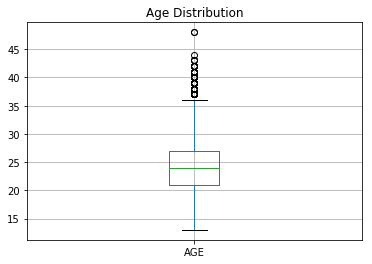

In [16]:
plt.title("Age Distribution")
athlete_events_df.dropna().boxplot("AGE")

Now, let's take a look to the scatterplot matrix for our data in order to try to find irregularities.

C:\Users\kthyb\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


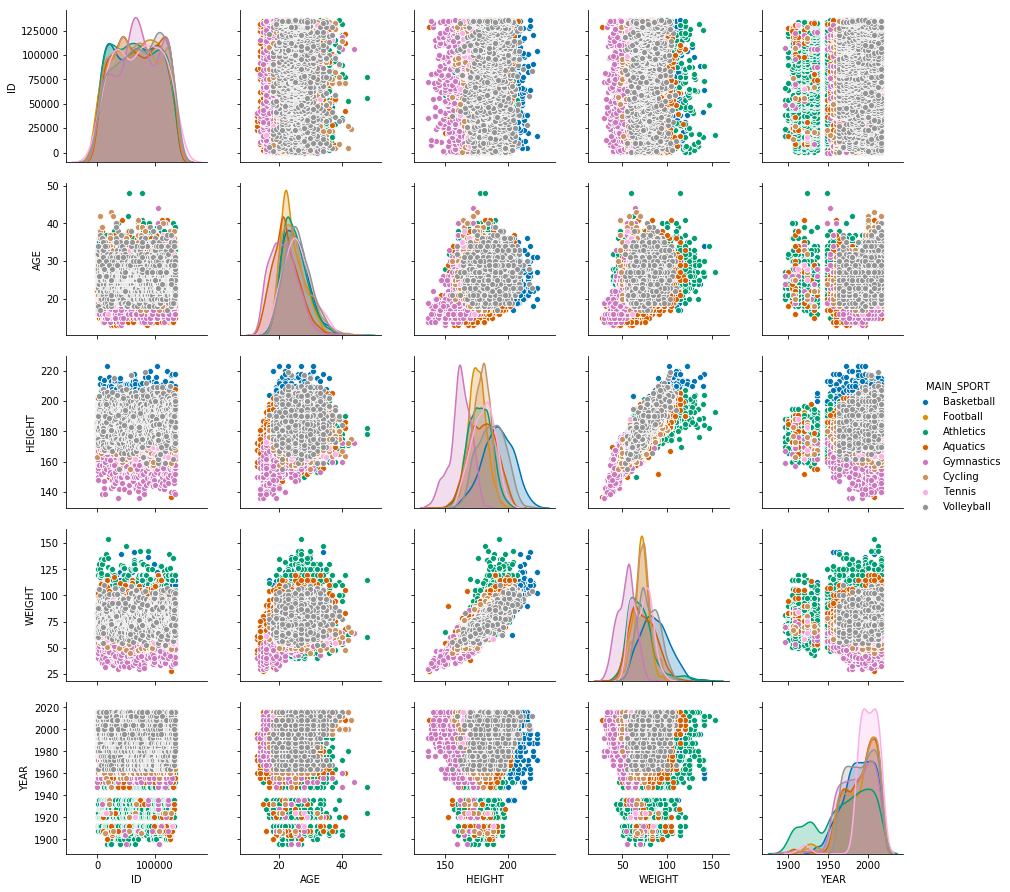

In [17]:
sb.pairplot(athlete_events_df.dropna(), hue="MAIN_SPORT",palette="colorblind")

We can observe the following things:
* There are 2 gaps between the Olympic years.
* Participations increase over time
* Height and weight are dependendant per sport, for example Basketball athletes tend to be the tallest and heaviest, while Gymnastics athletes tend to be the shortest and lightest.

Let's verify the 2 gaps between the Olympic years

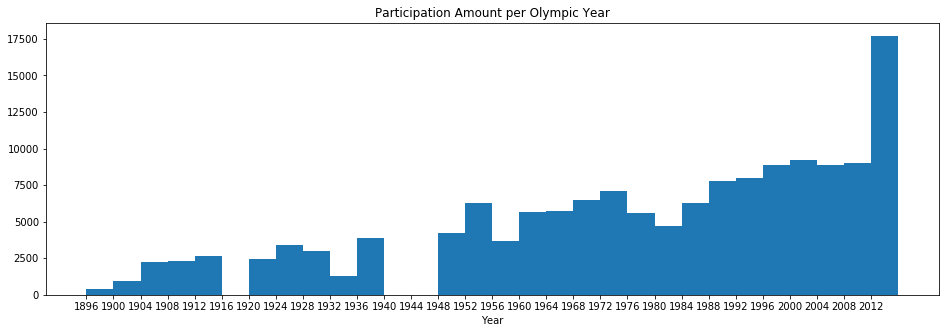

In [18]:
year_range = np.arange(athlete_events_df.YEAR.min(),athlete_events_df.YEAR.max(),4)

plt.figure(figsize=(16,5))
axes = plt.axes()
axes.set_xticks(year_range)
axes.set_xlabel("Year")
axes.set_title("Participation Amount per Olympic Year")
plt.hist(athlete_events_df.YEAR.values,bins = 30)
plt.show()

From the chart, we see that there's no data for 1916,1940 and 1944 Olympic Games, and if we verify with history, they were cancelled due to the outbreak of the World War 1 and 2.

Now, lets move on with the increase on participation for the most popular sports over years.
In order to achieve this, we used a simple moving average technique to forecast each Olympic Participant Amount per Sport, this is due to have a clearer vision over the chart.

<Figure size 1152x576 with 0 Axes>

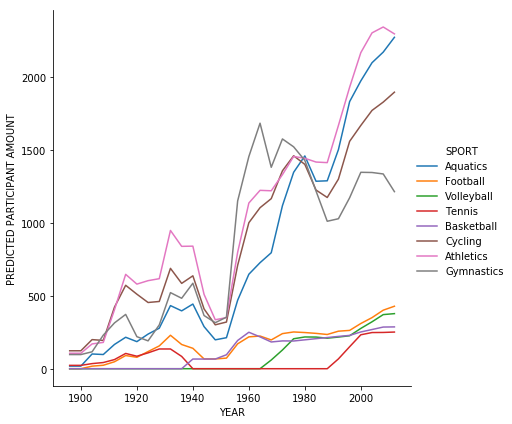

In [19]:
#Predicts each year participation amount based on the average of previous years.
def plot_year_trend_by_ma(df, ma = 3):
    #Obtaining the amount of participations per year for each sport
    sport_part_amount_per_year_df = df.groupby(by=["YEAR","MAIN_SPORT"]).size().reset_index(name="PARTICIPANT AMOUNT")

    #Not all sports had events in some years, so let's just create at least a record that represents 0 participations
    year_range = np.arange(df.YEAR.min(),df.YEAR.max(),4)
    year_range_df = pd.DataFrame({"YEAR": year_range, "KEY": np.ones(len(year_range))})
    sports = df.MAIN_SPORT.unique()
    sport_df = pd.DataFrame({"SPORT": sports, "KEY": np.ones(len(sports)) })
    sport_part_amount_per_year_df = sport_part_amount_per_year_df.merge(sport_df.merge(year_range_df, on="KEY"), left_on = ["MAIN_SPORT","YEAR"],
                                        right_on = ["SPORT", "YEAR"], how = "right").sort_values(by="YEAR")
    sport_part_amount_per_year_df = sport_part_amount_per_year_df.drop(["MAIN_SPORT","KEY"],axis=1)
    sport_part_amount_per_year_df = sport_part_amount_per_year_df.fillna({"PARTICIPANT AMOUNT": 0}).reset_index(drop=True)
    
    #Now lets try to predict each participation amount
    part_x_year_per_sport = sport_part_amount_per_year_df.groupby(by="SPORT")
    sport_part_amount_per_year_df["PREDICTED PARTICIPANT AMOUNT"] = sport_part_amount_per_year_df["PARTICIPANT AMOUNT"]
    for sport in sports:
        sport_data = part_x_year_per_sport.get_group(sport).sort_values(by="YEAR").reset_index(drop=False)
        valid_index = 0
        for index in sport_data.index.tolist():
            if index == 0:
                continue
            #Then obtain the average from the last averages
            if index < ma:
                sport_part_amount_per_year_df.loc[sport_data.loc[index,"index"], "PREDICTED PARTICIPANT AMOUNT"] = \
                sport_data.loc[0:index-1, "PARTICIPANT AMOUNT"].mean()
            #If there are enough values for the moving average, then predict
            if index >= ma:
                sport_part_amount_per_year_df.loc[sport_data.loc[index,"index"], "PREDICTED PARTICIPANT AMOUNT"] = \
                sport_data.loc[index-ma:index-1, "PARTICIPANT AMOUNT"].mean()
        
    #Plot the predicions    
    plt.figure(figsize=(16,8))
    sb.relplot(x="YEAR", y="PREDICTED PARTICIPANT AMOUNT",hue="SPORT", kind="line", data=sport_part_amount_per_year_df, height = 6, aspect = 1)
plot_year_trend_by_ma(athlete_events_df)

 We can se the different trends per sport. The sports that have significant increases are the individual type such as Gymnastics, Athletics, Cycling and Aquatics, this is probably for the addition of new events per discipline. Meanwhile team sports (Volleyball, Football, Tennis and Basketball) are quite steady, also we observed that some of them where new at the Olympics since 1960.

Finally, we want to observe if there's really a dependency between height, weight and sport. Since the dataset contains female and male athletes, we find it critical to visualize this aspect for both genders, due to physiological attributes.

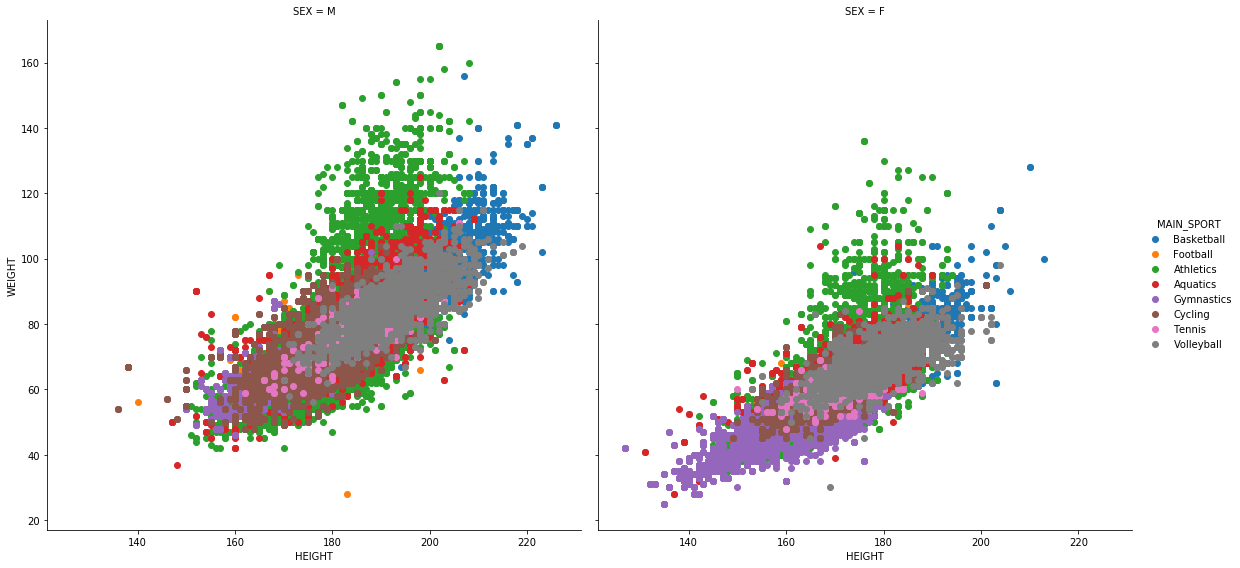

In [20]:
g = sb.FacetGrid(athlete_events_df, col = "SEX", hue="MAIN_SPORT", height=8, aspect=1)
g.map(plt.scatter, "HEIGHT","WEIGHT");
g.add_legend()

In [21]:
athlete_events_df.groupby(by=["SEX","MAIN_SPORT"]).agg({"HEIGHT":np.mean, "WEIGHT": np.mean}).reset_index()

,SEX,MAIN_SPORT,HEIGHT,WEIGHT
0,F,Aquatics,170.485746,60.721123
1,F,Athletics,169.285714,60.239798
2,F,Basketball,182.454836,73.685170
3,F,Cycling,168.018629,59.770553
4,F,Football,167.676142,60.925813
5,F,Gymnastics,157.081466,47.909701
6,F,Tennis,172.335736,62.094398
7,F,Volleyball,179.398867,69.185795
8,M,Aquatics,183.723069,78.785494
9,M,Athletics,179.768303,73.839129


We observe that there's a different distribution per sport, some of them overlap, but there are sports where the height and weight is higher or lower.

_______

We found the following:

It seems that there are some missing values for the following columns:
* Age
* Height
* Weight
* Medal

and from the previous charts, we found the following:
* There's some missing data for the 1916 and 1940 Olympics, since they were cancelled due to the outbreak of the World War 1 and 2.
* The majority of popular summer sports have more participations after 1950.
* Height and Weight are correlated, and both of them are dependent from the sport and gender.
* There are some outliers on the age column, since around 90% of users have an age between 17 and 32 years.


<h2><font color='#0E2545'>Step 3. Data Tidying</font></h2>

<a href="#Table-of-Contents">Got top &uarr;</a>

In [22]:
from sklearn.preprocessing import Imputer

First, let's just consider results between 1950 to 2016. Also, we are removing users that are older than 32 years and younger than 17.

In [23]:
athlete_events_cp_df = athlete_events_df.copy()
athlete_events_cp_df = athlete_events_cp_df[athlete_events_cp_df.YEAR >=1950]

athlete_events_cp_df = athlete_events_cp_df[((athlete_events_cp_df.AGE >= 17) & (athlete_events_cp_df.AGE <= 32)) | (athlete_events_cp_df.AGE.isna())]

print("Considered Years:",np.sort(athlete_events_cp_df.YEAR.unique()))

Considered Years: [1952 1956 1960 1964 1968 1972 1976 1980 1984 1988 1992 1996 2000 2004
 2008 2012 2016]


Now, let's handle each missing value

**Medal**

An athlete can only win:
 * Gold
 * Silver
 * Bronze


**Age**

The average age for an athlete is 24 years.

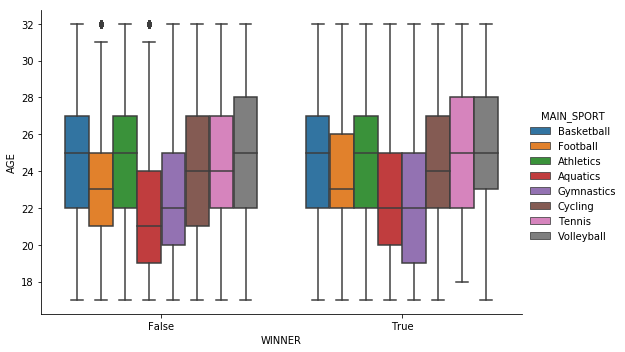

In [122]:
athlete_events_cp_df["WINNER"] = athlete_events_cp_df["MEDAL"] != "No Medal"

athlete_events_cp_df = athlete_events_cp_df.fillna({"MEDAL": 'No Medal', "AGE": np.round(athlete_events_cp_df["AGE"].mean())})

sb.catplot(x="WINNER", y="AGE",hue="MAIN_SPORT", kind="box", data=athlete_events_cp_df, height=5,aspect=1.5);

Nice, now we removed the age missing values and outliers and defined which athletes were winners.

**Height and Weight**

Now it is time to fix the missing values for the Height and Weight. We know that both features are dependent per sport and gender.

In [25]:
# We consider that Height and Weight vary per Sport and Gender, so we decided to create an imputer
#that treats this

def clean_columns_by_imputer(df, groupby, missing_columns, stategy = 'mean'):
    missing_columns_x_mean = {}
    global_means = df[missing_columns].mean()
    for mc in missing_columns:
        missing_columns_x_mean[mc] = global_means[mc]
    df = df.groupby(groupby)
    for name, group in df:
        if group[group[missing_columns].isna()].shape == group.shape:
            group = group.fillna(missing_columns_x_mean)
            yield group
        imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
        imputer = imputer.fit(group[missing_columns].values)
        group[missing_columns] = imputer.transform(group[missing_columns].values)
        yield group

In [26]:
##Iterate per every group and fix missing values
for group in clean_columns_by_imputer(athlete_events_cp_df.copy().reset_index(),["MAIN_SPORT","SEX"], ["HEIGHT","WEIGHT"]):
    athlete_events_cp_df.loc[group["index"].values,"HEIGHT"] = group.loc[:,"HEIGHT"].values
    athlete_events_cp_df.loc[group["index"].values,"WEIGHT"] = group.loc[:,"WEIGHT"].values
athlete_events_cp_df[["ID","HEIGHT","WEIGHT"]].describe()

,ID,HEIGHT,WEIGHT
count,109936.000000,109936.000000,109936.000000
mean,67944.016746,175.812480,69.215261
std,39209.639874,10.339934,12.686349
min,1.000000,131.000000,28.000000
25%,34031.500000,169.000000,61.000000
50%,68367.500000,175.812480,69.215261
75%,101692.000000,182.000000,75.000000
max,135566.000000,226.000000,165.000000


We want to reduce the amount of features, in this case we can add the BMI as dependent variable of Height and Weight

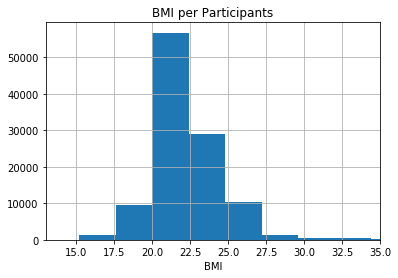

In [27]:
athlete_events_cp_df["BMI"] = np.round((athlete_events_cp_df["WEIGHT"])/(athlete_events_cp_df["HEIGHT"]/100)**2)
axes = plt.axes()
axes.set_title("BMI per Participants")
axes.set_xlabel("BMI")
axes.set_xlim([13,35])
athlete_events_cp_df["BMI"].hist(bins=15)

Most athletes have a BMI between 20-24, which it means they have Normal body mass.

After cleaning the data, let's decide the attributes the most useful:
* SEX
* AGE
* BMI
* NOC
* YEAR
* DISCIPLINE
* MAIN_SPORT
* CATEGORY
* TYPE
* WINNER


In [28]:
athlete_events_clean_df = athlete_events_cp_df[["SEX","AGE","BMI","NOC","YEAR","DISCIPLINE", "EVENT",
                                             "MAIN_SPORT","CATEGORY","TYPE","MEDAL","WINNER"]]
athlete_events_clean_df.WINNER = athlete_events_clean_df.WINNER.astype("float64")
athlete_events_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109936 entries, 0 to 147620
Data columns (total 12 columns):
SEX           109936 non-null object
AGE           109936 non-null float64
BMI           109936 non-null float64
NOC           109936 non-null object
YEAR          109936 non-null int64
DISCIPLINE    109936 non-null object
EVENT         109936 non-null object
MAIN_SPORT    109936 non-null object
CATEGORY      109936 non-null object
TYPE          109936 non-null object
MEDAL         109936 non-null object
WINNER        109936 non-null float64
dtypes: float64(3), int64(1), object(8)
memory usage: 15.9+ MB


C:\Users\kthyb\Anaconda3\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [29]:
#Just in case we want to avoid data cleansing
athlete_events_clean_df.to_csv("athlete_events_clean.csv",index = False)

Now, our data is ready for analysis, we solved each issue defined at the beginning of the step.

<h2><font color='#0E2545'>Step 4. Exploratory Analysis</font></h2>

<a href="#Table-of-Contents">Got top &uarr;</a>

In [30]:
athlete_events_clean_df = pd.read_csv("athlete_events_clean.csv")
athlete_events_clean_df.head(5)

,SEX,AGE,BMI,NOC,YEAR,DISCIPLINE,EVENT,MAIN_SPORT,CATEGORY,TYPE,MEDAL,WINNER
0,M,24.0,25.0,CHN,1992,Basketball,Basketball Men's Basketball,Basketball,B,Team,No Medal,1.0
1,F,19.0,21.0,ESP,2008,Basketball,Basketball Women's Basketball,Basketball,B,Team,No Medal,1.0
2,M,31.0,22.0,EGY,1952,Basketball,Basketball Men's Basketball,Basketball,B,Team,No Medal,1.0
3,M,29.0,22.0,ITA,2000,Basketball,Basketball Men's Basketball,Basketball,B,Team,No Medal,1.0
4,M,25.0,24.0,EGY,1972,Basketball,Basketball Men's Basketball,Basketball,B,Team,No Medal,1.0


In [46]:
def global_medal_winners(df, medal,year = None):
    cmap = plt.cm.get_cmap("Accent")
    colors = cmap(np.arange(cmap.N))
    if year is not None:
        df = df[df.YEAR >= year]
    df = df.groupby(by = ["NOC","MEDAL"]).size().reset_index(name = "AMOUNT").sort_values(by="AMOUNT", ascending=False).head(10)
    plt.figure(figsize=(12,5))
    plt.title("Overall - Top 10 " + medal + " Winners. Since " + str(year))
    plt.bar(df.NOC,df.AMOUNT,color=colors)
    
def top_medal_winners(df, medal,year = None):
    if year is not None:
        df = df[df.YEAR >= year]
    sports = df.MAIN_SPORT.unique()
    df = df.groupby(by = ["MAIN_SPORT","NOC","MEDAL"]).size().reset_index(name = "AMOUNT")
    df = df[df.MEDAL == medal].groupby(by="MAIN_SPORT")
    plt.figure(figsize=(20,10))
    chart_lim_per_row = 4
    rows = round(len(sports)/4)
    cmap = plt.cm.get_cmap("Accent")
    colors = cmap(np.arange(cmap.N))
    for index,sport in enumerate(sports):
        plt.subplot(rows,chart_lim_per_row,index + 1)
        top_winners = df.get_group(sport).sort_values(by="AMOUNT", ascending=False).head(5)
        plt.title(sport + "- Top 5 " + medal + " Winners.  Since " + str(year))
        plt.bar(top_winners.NOC,top_winners.AMOUNT, color=colors)

It's time to discover which are the possible bets that we can do. For this step, we're going to separate our data by gender, male and female 

In [47]:
women_events_df = athlete_events_clean_df[athlete_events_clean_df.SEX == "F"]
print("Women Participations", women_events_df.shape[0])
men_events_df = athlete_events_clean_df[athlete_events_clean_df.SEX == "M"]
print("Men Participations", men_events_df.shape[0])

Women Participations 34778
Men Participations 75158


<h3>4.A Women Participations</h3>

<a href="#Table-of-Contents">Got top &uarr;</a>

We are curious to know how women participation changed during years, since we know that most events were just for men, and for some editions, women events were newly incorporated.

<Figure size 1152x576 with 0 Axes>

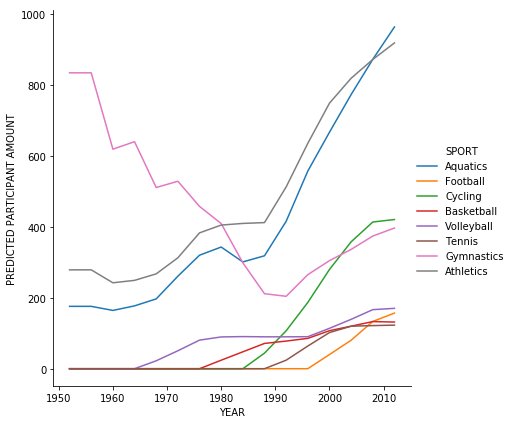

In [62]:
plot_year_trend_by_ma(women_events_df,ma=3)

We observe the following:
* For Gymnastics, participation decreased between 1960 to 1990, but then it begins to increase after 1990.
* Aquatics and Athletics are the ones with more participations.
* Team sports, such as  Basketball, Volleyball, Tennis (couples), and Football were incorporated after 1960.

After noticing the trends per sport, lets see which countries are the top winners.

Let's consider first since 1950.

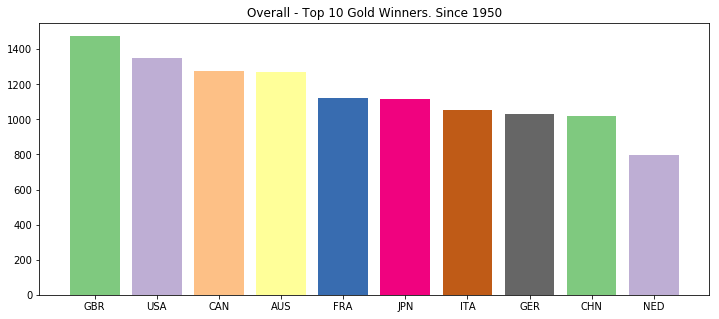

In [63]:
global_medal_winners(women_events_df,"Gold",1950)

If we consider all gold winners since 1950, we observe that the top winners are:
- Great Britain
- USA
- Canada

But, lets see which are the ones that are leaders for the last 30 years.

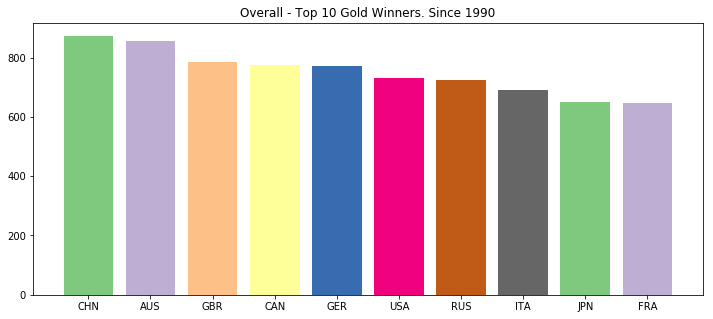

In [64]:
global_medal_winners(women_events_df,"Gold",1990)

It seems that China and Australia had become the top winners for the past 30 years.
This tells us that maybe relying on too old records might affect our predictions, since maybe some countries, that were winners before, aren't recently winning on a discipline.

Now, lets figure out which are the top winners per sport

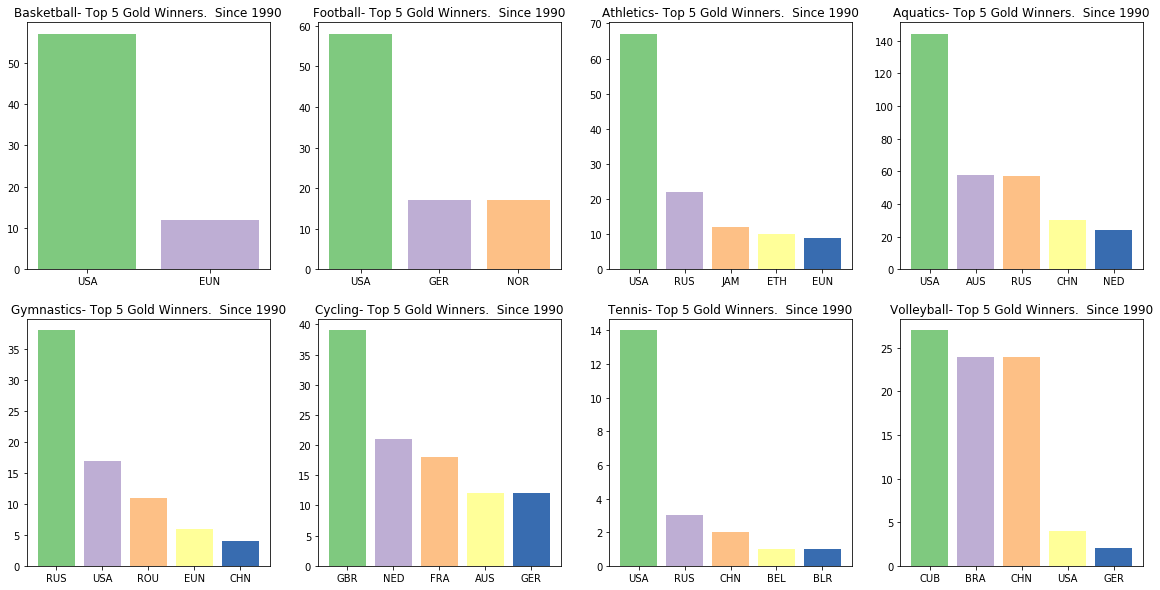

In [115]:
top_medal_winners(women_events_df,"Gold",1990)

Visualizing the distributions per sport, we notice that some countries have a noticeable domain on the sport, for example USA is the leader for the majority of the considered sports (Basketball, Football, Athletics, Aquatics, Tennis).

<h3>4.B. Can we know if an athlete will win gold just based on his/her nationality?</h3>
<a href="#Table-of-Contents">Got top &uarr;</a>

We have the hypothesis that usually the same countries win a certain discipline, so in order to prove that there's a relation between winning a medal and being from certain country, we decided to use Bayes' Theorem.
$$P(\textbf{A}|\textbf{B}) = P(\textbf{A} ) \frac{P(\textbf{B} |\textbf{A})}{P(\textbf{B})}$$

Where, the conditional probability is: $$P(\textbf{B} |\textbf{A}) = \frac{P(\textbf{A} \cap \textbf{B})}{P(\textbf{A})}$$
So as an example, we asked ourselves if there is a relation between winning gold in Rhythmic Gymnastics if an athlete is from Russia?
Well, what is given is the athlete's nationality, so what we really need to know is the probability of this athlete on winning gold. Then, we need to obtain the following:
$$P(\textbf{Gold}|\textbf{Russian}) = P(\textbf{Gold} ) \frac{P(\textbf{Russian} |\textbf{Gold})}{P(\textbf{Russian})}$$

   $$P(\textbf{Gold}) = \text{Probability of winning gold}$$
   $$P(\textbf{Russian}) = \text{Probability of being from Russia}$$
   $$P(\textbf{Gold} \cap \textbf{Russian}) = \text{Probability of being from Russia and winning Gold}$$
   $$P(\textbf{Russian} |\textbf{Gold}) = \text{ The likelihood of being from Russia when the event of winning Gold is True}$$

Let's try to prove this hypothesis by using Naive Bayes, our model will try to classify if an athlete is a Gold winner just based on his/her nationality.